In [1]:
import pandas as pd
import covasim as cv

from util import comb

Covasim 2.0.2 (2020-02-01) — © 2021 by IDM


# Simulator

## Covasim

**Covasim** is a stochastic agent-based simulator for performing COVID-19 analyses. These include projections of indicators such as numbers of infections and peak hospital demand. It can also be used to explore the potential impact of different interventions, including social distancing, school closures, testing, contact tracing, quarantine, and vaccination.

The scientific paper describing Covasim is available at http://paper.covasim.org.

## Running a Simulation

Running simulations in Covasim can be done using the `cv.Sim()` command, which accepts a dictionary of simulation parameters. The most common parameters to modify are the population size, the initial number of people infected, and the start and end dates of the simulation. The comprehensive list of parameters is available [here](https://docs.idmod.org/projects/covasim/en/latest/parameters.html).

Here, we fix the population size to `10000` and we use the `hybrid` population type, which guarantees the best trade-off between computational cost and realistic interaction among agents.

In [2]:
pars = dict(
  pop_type='hybrid',
  pop_size=10000
)

sim = cv.Sim(pars)

These are the default values of some parameters which may be of interest.

In [3]:
parameters = [
 'beta',         # beta per symptomatic contact
 'contacts',     # the number of contacts per layer
 'dynam_layer',  # which layers are dynamic
 'beta_layer',   # transmissibility per layer
 'n_imports',    # average daily number of imported cases (actual number is drawn from Poisson distribution)
 'asymp_factor', # multiply beta by this factor for asymptomatic cases; no statistically significant difference in transmissibility
 'iso_factor',   # multiply beta by this factor for diganosed cases to represent isolation
 'quar_factor',  # quarantine multiplier on transmissibility and susceptibility
 'quar_period'   # number of days to quarantine for
]

for key in parameters:
  print(f'{key:13} --> {sim[key]}')

beta          --> 0.016
contacts      --> {'h': 2.0, 's': 20, 'w': 16, 'c': 20}
dynam_layer   --> {'h': 0, 's': 0, 'w': 0, 'c': 0}
beta_layer    --> {'h': 3.0, 's': 0.6, 'w': 0.6, 'c': 0.3}
n_imports     --> 0
asymp_factor  --> 1.0
iso_factor    --> {'h': 0.3, 's': 0.1, 'w': 0.1, 'c': 0.1}
quar_factor   --> {'h': 0.6, 's': 0.2, 'w': 0.2, 'c': 0.2}
quar_period   --> 14


The execution of a simulation produces the following results:

In [4]:
sim.run()

Initializing sim with 10000 people for 60 days
  Running 2020-03-01 ( 0/60) (0.56 s)  ———————————————————— 2%
  Running 2020-03-11 (10/60) (0.64 s)  •••————————————————— 18%
  Running 2020-03-21 (20/60) (0.72 s)  ••••••—————————————— 34%
  Running 2020-03-31 (30/60) (0.83 s)  ••••••••••—————————— 51%
  Running 2020-04-10 (40/60) (0.92 s)  •••••••••••••——————— 67%
  Running 2020-04-20 (50/60) (1.01 s)  ••••••••••••••••———— 84%
  Running 2020-04-30 (60/60) (1.14 s)  •••••••••••••••••••• 100%

Simulation summary:
    6342 cumulative infections
    5377 cumulative infectious
       0 cumulative tests
       0 cumulative diagnoses
    3066 cumulative recoveries
    3494 cumulative symptomatic cases
     205 cumulative severe cases
      49 cumulative critical cases
       9 cumulative deaths
       0 cumulative quarantined people



## Running multiple simulations

As we are aiming to use Covasim to generate realistic data, we will need to run more than one simulation simultaneously. The most common way to run multiple simulations is with the `MultiSim` object. As the name suggests, this is a relatively simple container for a number of sims. However, it contains powerful methods for plotting, statistics, and running all the sims in parallel.

In [5]:
multi_pars = [ (k, v) for k, v in dict(
  rand_seed = range(3),
  beta = [0.01, 0.02, 0.03]
).items()]

multi_pars

[('rand_seed', range(0, 3)), ('beta', [0.01, 0.02, 0.03])]

We rely on our utility function `cartesian_product` to generate a list of python dictionaries containing all the possible combinations of the parameters that we are willing to explore. In the end, the total number of configurations will be given by the product of the number of values which can be assumed by each variable parameter. E.g., in this case, we have three possible values for `rand_seed` and three possible values for `beta`, for a total of $3 \cdot 3 = 9$ configurations.

In [6]:
fixed_pars = dict(
  pop_type='hybrid',
  pop_size=10000,
  verbose=0
)

pars_list = comb.cartesian_product(multi_pars, fixed_pars)
len(pars_list)

9

We can now map each configuration into a Covasim `Sim` object, and then create and run the `MultiSim`.

In [7]:
sims = [cv.Sim(pars, label=f'Sim {i}') for i, pars in enumerate(pars_list)]
msim = cv.MultiSim(sims)
msim.brief()

MultiSim(n_sims: 9; base: Sim("Sim 0"; 2020-03-01 to 2020-04-30; pop: 10000 hybrid; epi: not run))


In [8]:
%%time
msim.run()

CPU times: user 68.2 ms, sys: 46.4 ms, total: 115 ms
Wall time: 6.51 s


Finally, we collect the results of each simulation into a pandas dataframe. Of all the possible outputs returned by a simulation, we just keep the *cumulative* data, namely the statistics regarding the entire simulation span and not just the final simulated day.

In [9]:
keys = [key for key in msim.sims[0].summary.keys() if 'cum' in key]
values = [sim.summary[keys] for sim in msim.sims]

pd.DataFrame(values, columns=keys)

,cum_infections,cum_infectious,cum_tests,cum_diagnoses,cum_recoveries,cum_symptomatic,cum_severe,cum_critical,cum_deaths,cum_quarantined
0,1653.0,1358.0,0.0,0.0,917.0,919.0,53.0,12.0,2.0,0.0
1,8280.0,7827.0,0.0,0.0,5824.0,5174.0,354.0,79.0,24.0,0.0
2,9367.0,9356.0,0.0,0.0,9123.0,6332.0,524.0,141.0,55.0,0.0
3,1164.0,945.0,0.0,0.0,569.0,621.0,31.0,9.0,1.0,0.0
4,8266.0,7686.0,0.0,0.0,5449.0,5103.0,363.0,89.0,17.0,0.0
5,9376.0,9348.0,0.0,0.0,8990.0,6306.0,520.0,146.0,60.0,0.0
6,2908.0,2414.0,0.0,0.0,1518.0,1580.0,83.0,20.0,4.0,0.0
7,8810.0,8664.0,0.0,0.0,7650.0,5846.0,433.0,108.0,35.0,0.0
8,9493.0,9487.0,0.0,0.0,9282.0,6363.0,505.0,149.0,46.0,0.0


## Interventions

It is possible to modify the parameters of the simulation during the execution via a set of explicit rules. This can come handy to reproduce the effect of countermeasures like lockdowns, contact tracing, and vaccines.

A vaccine given on days 30 and 44 (two weeks later), with efficacy of 50% per dose which accumulates, given to 60% of the population, and which blocks 50% of acquisition and (among those who get infected even so) 90% of symptoms, would look like this:

In [10]:
vaccine = cv.vaccine(days=[30, 44], 
                     cumulative=[0.5, 0.5], 
                     prob=0.6, 
                     rel_sus=0.5, 
                     rel_symp=0.1)

In [11]:
base_pars = dict(
  pop_type='hybrid',
  pop_size=10000,
  n_days=90,
  verbose=0
)

sim_base = cv.Sim(base_pars, label="Base")
sim_vaccine = cv.Sim(base_pars, interventions=vaccine, label="Vaccine")
msim = cv.MultiSim([sim_base, sim_vaccine])
msim.run()
msim.summarize()

MultiSim summary:
  Number of sims: 2
  Reduced/combined: None
  Base: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: not run)
  Sims:
    0: Sim("Base"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 8106⚙, 39☠)
    1: Sim("Vaccine"; 2020-03-01 to 2020-05-30; pop: 10000 hybrid; epi: 6275⚙, 18☠)



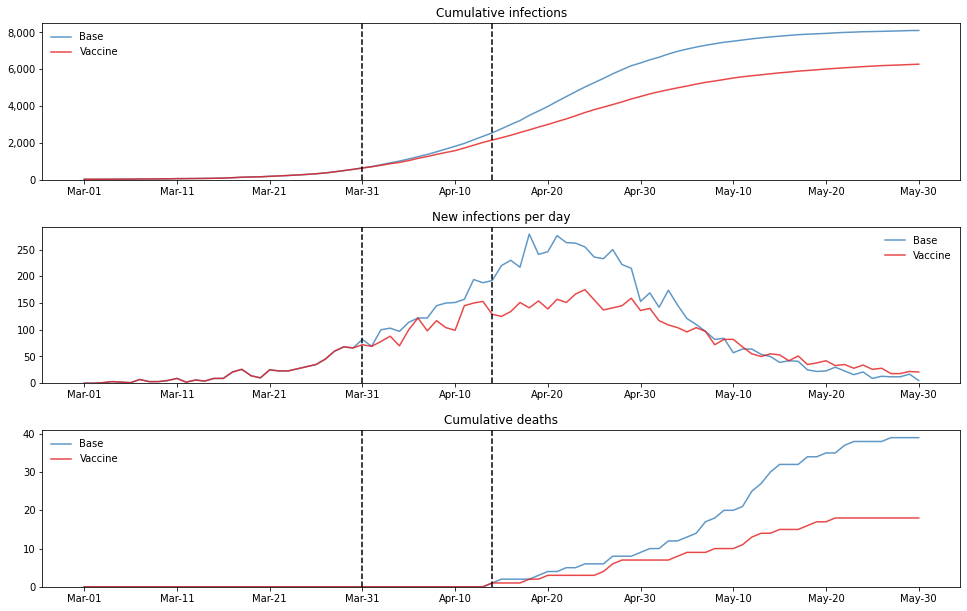

In [18]:
msim.plot(fig_args={"figsize": (15, 9)});

# Generate the Dataset

## Scenario

We start by choosing a range of fixed parameters that define our scenario. As we will consider the evolution of the pandemic in Italy, we need to fix the location (which implicitly changes some behavioural and cultural aspects of the population, according to data that can be inspected with `cv.data.show_locations()`) and the information about hospital capacities, which has been retrieved from [Wikipedia](https://en.wikipedia.org/wiki/List_of_countries_by_hospital_beds). The simulation is run for 180 days and a populaion of 50k agents, which could represent a medium-size city, with a 0.1% of initially infected individuals.

In [13]:
fixed_params = {}
fixed_params['pop_type'] = 'hybrid'                                  # hybrid population type (four default contact layers included)
fixed_params['location'] = 'italy'                                   # households and age distribution data from italy
fixed_params['n_days'] = 180                                         # 6-months simulation
fixed_params['pop_size'] = 50e3                                      # 50k agents in total
fixed_params['pop_infected'] = fixed_params['pop_size'] / 1e3        # 1 initial infected per 1k agents
fixed_params['n_beds_hosp'] = fixed_params['pop_size'] * 3.18 / 1e3  # 3.18 hospital beds per 1k citizens
fixed_params['n_beds_icu'] = fixed_params['pop_size'] * 12.5 / 100e3 # 12.5 hospital beds per 100k citizens
fixed_params['verbose'] = 0                                          # suppress prints

Now, we define the variable parameters that will be used to generate our dataset.

In [14]:
multi_params = [ (k, v) for k, v in dict(
  rand_seed = range(3),                                              # 3 simulations per input values
  n_imports = [5, 10],                                               # number of imported index cases
  quar_period = [7, 14],                                             # length of the quarantine period in days
).items() ]

In [15]:
params_list = comb.cartesian_product(multi_params, fixed_params)
simulations = [cv.Sim(params, label=f'Sim {i}') for i, params in enumerate(params_list)]
multi_sim = cv.MultiSim(simulations)
multi_sim.run()

input_keys = [key for key, _ in multi_params]
output_keys = [key for key in multi_sim.sims[0].summary.keys() if 'cum' in key]
values = []
for i, simulation in enumerate(multi_sim.sims):
  input_values = [params_list[i][key] for key in input_keys]
  output_values = simulation.summary[output_keys]
  values.append(input_values + output_values)

Finally, we can collect the results in a dataframe.

In [16]:
df = pd.DataFrame(values, columns=input_keys + output_keys)
df.to_csv('data/covasim.csv')
df

,rand_seed,n_imports,quar_period,cum_infections,cum_infectious,cum_tests,cum_diagnoses,cum_recoveries,cum_symptomatic,cum_severe,cum_critical,cum_deaths,cum_quarantined
0,0,5,7,40560.0,40553.0,0.0,0.0,39366.0,28756.0,3072.0,1732.0,1169.0,0.0
1,0,5,14,40560.0,40553.0,0.0,0.0,39366.0,28756.0,3072.0,1732.0,1169.0,0.0
2,0,10,7,40872.0,40858.0,0.0,0.0,39604.0,28779.0,3116.0,1804.0,1236.0,0.0
3,0,10,14,40872.0,40858.0,0.0,0.0,39604.0,28779.0,3116.0,1804.0,1236.0,0.0
4,1,5,7,40576.0,40568.0,0.0,0.0,39351.0,28890.0,3133.0,1754.0,1204.0,0.0
5,1,5,14,40576.0,40568.0,0.0,0.0,39351.0,28890.0,3133.0,1754.0,1204.0,0.0
6,1,10,7,40782.0,40773.0,0.0,0.0,39559.0,28830.0,3082.0,1723.0,1191.0,0.0
7,1,10,14,40782.0,40773.0,0.0,0.0,39559.0,28830.0,3082.0,1723.0,1191.0,0.0
8,2,5,7,40282.0,40279.0,0.0,0.0,39044.0,28480.0,2982.0,1708.0,1222.0,0.0
9,2,5,14,40282.0,40279.0,0.0,0.0,39044.0,28480.0,2982.0,1708.0,1222.0,0.0
